## from EDA to ML

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../Data/train.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


| **Feature**      | **Description**                                            | **Action**                                                                                           |
|-------------------|------------------------------------------------------------|-----------------------------------------------------------------------------------------------------|
| **PassengerId**   | Unique identifier for each passenger                       | No action needed; it’s just an identifier and not useful for modeling.                             |
| **Survived**      | Indicates survival (1 = survived, 0 = not survived)        | Check for class imbalance and visualize distribution.                                               |
| **Pclass**        | Passenger class (1st, 2nd, 3rd)                            | Convert to categorical if needed; analyze distribution and relationship with `Survived`.            |
| **Name**          | Passenger’s full name                                      | Extract titles (e.g., Mr., Mrs.) as a new feature; drop the full name if unnecessary.               |
| **Sex**           | Passenger’s gender                                         | Encode as binary (e.g., 0 for male, 1 for female); analyze relationship with `Survived`.            |
| **Age**           | Passenger’s age                                            | Handle missing values (impute); analyze distribution and outliers; consider binning into age groups.|
| **SibSp**         | Number of siblings/spouses aboard                          | Analyze distribution; combine with `Parch` to create a `FamilySize` feature.                       |
| **Parch**         | Number of parents/children aboard                          | Analyze distribution; combine with `SibSp` for `FamilySize`.                                       |
| **Ticket**        | Ticket number                                              | Check for duplicate tickets; consider extracting ticket prefixes as a categorical feature.          |
| **Fare**          | Ticket fare                                                | Handle outliers; analyze distribution; consider scaling or normalizing due to potential skewness.   |
| **Cabin**         | Cabin number (if available)                                | Create a feature indicating whether the cabin is known; drop or preprocess the full cabin data.     |
| **Embarked**      | Port of embarkation (C, Q, S)                              | Handle missing values (impute with mode); encode as categorical; analyze distribution.              |


---
---

### **1. Data Cleaning**
   - Check for missing values in each column.
   - Handle missing values:
     - For `Age`, consider using imputation (mean, median, or predictive modeling).
     - For `Cabin`, decide whether to drop it or create a new feature indicating whether a cabin is known or not.
     - For `Embarked`, impute the missing values with the mode or another strategy.
   - Verify data types and ensure proper type casting (e.g., categorical variables like `Pclass`, `Sex`, and `Embarked` should be converted to categorical types if needed).
   - Remove duplicates (if any).
   - Strip unnecessary spaces or characters from string columns.

In [4]:
df['Pclass'] = df['Pclass'].astype('category')
df['Sex'] = df['Sex'].astype('category')
df['Embarked'] = df['Embarked'].astype('category')

In [5]:
decimal_ages = df['Age'].dropna().apply(lambda x: x % 1 != 0)
print("Rows with non-integer Age values:")
df.loc[decimal_ages.index[decimal_ages][:5]]

Rows with non-integer Age values:


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
57,58,0,3,"Novel, Mr. Mansouer",male,28.50,0,0,2697,7.2292,NaN,C
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
111,112,0,3,"Zabour, Miss. Hileni",female,14.50,1,0,2665,14.4542,NaN,C
116,117,0,3,"Connors, Mr. Patrick",male,70.50,0,0,370369,7.7500,NaN,Q
122,123,0,2,"Nasser, Mr. Nicholas",male,32.50,1,0,237736,30.0708,NaN,C


In [6]:
negative_age_rows = df[df['Age'] < 3]

if not negative_age_rows.empty:
    print("Passengers with Age < 0 and their survival status:")
    print(negative_age_rows[['Age', 'Survived']])
else:
    print("No passengers have Age < 0.")

Passengers with Age < 0 and their survival status:
      Age  Survived
7    2.00         0
16   2.00         0
78   0.83         1
119  2.00         0
164  1.00         0
172  1.00         1
183  1.00         1
205  2.00         0
297  2.00         0
305  0.92         1
340  2.00         1
381  1.00         1
386  1.00         0
469  0.75         1
479  2.00         1
530  2.00         1
642  2.00         0
644  0.75         1
755  0.67         1
788  1.00         1
803  0.42         1
824  2.00         0
827  1.00         1
831  0.83         1


In [7]:
df.duplicated().sum()

0

In [8]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
df['Has_Cabin'] = df['Cabin'].notnull().astype(int)

In [10]:
df.drop(columns=['Cabin' , 'PassengerId'], inplace=True)

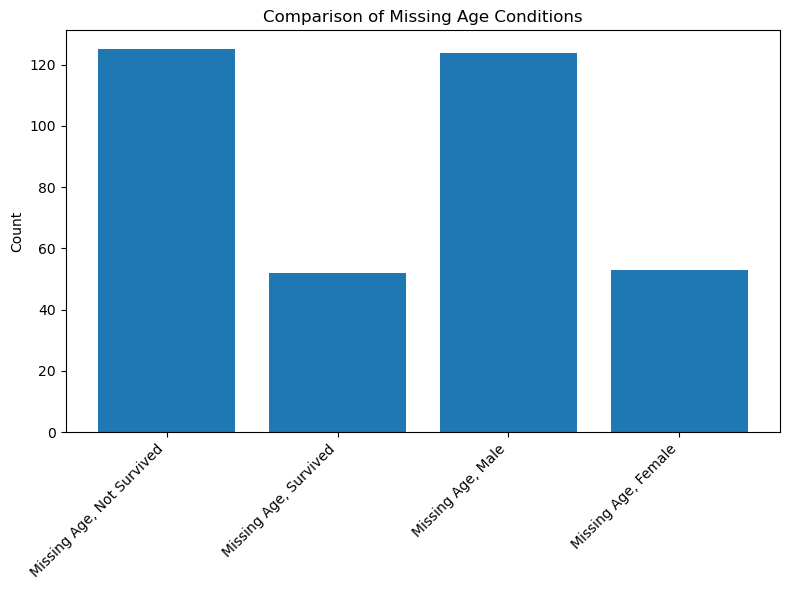

In [11]:
missing_age_not_survived = df[(df['Age'].isnull()) & (df['Survived'] == 0)].shape[0]
missing_age_survived = df[(df['Age'].isnull()) & (df['Survived'] == 1)].shape[0]
missing_age_male = df[(df['Sex'] == 'male') & (df['Age'].isnull())].shape[0]
missing_age_female = df[(df['Sex'] == 'female') & (df['Age'].isnull())].shape[0]

counts = {
    'Missing Age, Not Survived': missing_age_not_survived,
    'Missing Age, Survived': missing_age_survived,
    'Missing Age, Male': missing_age_male,
    'Missing Age, Female': missing_age_female
}

plt.figure(figsize=(8, 6))
plt.bar(counts.keys(), counts.values())
plt.title("Comparison of Missing Age Conditions")
plt.ylabel("Count")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
df[(df['Sex'] == 'male') & (df['Age'].isnull()) & (df['Survived'] == 1)].shape[0]

16

In [13]:
df[(df['Sex'] == 'female') & (df['Age'].isnull()) & (df['Survived'] == 1)].shape[0]

36

In [14]:
df.Ticket.value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

In [15]:
df.Name.value_counts()

Name
Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: count, Length: 891, dtype: int64

In [16]:
df['Ticket_Number'] = df['Ticket'].str.extract(r'(\d+)$')

In [17]:
len(df.Ticket_Number.unique())

679

In [18]:
len(df.Ticket.unique())

681

In [19]:
df.Ticket_Number.value_counts()

Ticket_Number
1601       7
347082     7
2343       7
3101295    6
2144       6
          ..
9234       1
19988      1
2693       1
17612      1
370376     1
Name: count, Length: 678, dtype: int64

In [20]:
df['Title'] = df['Name'].str.extract(r',\s*(\w+)\.')

In [21]:
df.Title.value_counts()

Title
Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Don           1
Mme           1
Ms            1
Lady          1
Sir           1
Capt          1
Jonkheer      1
Name: count, dtype: int64

In [22]:
def fill_age_by_title(row):
    if pd.isnull(row['Age']):
        return df.groupby('Title')['Age'].median()[row['Title']]
    return row['Age']

In [23]:
df.Age = df.apply(fill_age_by_title , axis=1)

In [24]:
title_mapping = {
    'Mr': 'Mr',
    'Miss': 'Miss',
    'Mrs': 'Mrs',
    'Master': 'Master',
    'Dr': 'Professional/Military',
    'Rev': 'Professional/Military',
    'Major': 'Professional/Military',
    'Col': 'Professional/Military',
    'Capt': 'Professional/Military',
    'Don': 'Professional/Military',
    'Mme': 'Miss',
    'Ms': 'Miss',
    'Mlle': 'Miss',
    'Lady': 'Royalty/Nobility',
    'Sir': 'Royalty/Nobility',
    'Jonkheer': 'Royalty/Nobility'
}

In [25]:
df['Title_Grouped'] = df['Title'].map(title_mapping)

In [26]:
df.isnull().sum()

Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Has_Cabin        0
Ticket_Number    4
Title            1
Title_Grouped    1
dtype: int64

In [27]:
df[df['Ticket_Number'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin,Ticket_Number,Title,Title_Grouped
179,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,S,0,NaN,Mr,Mr
271,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,S,0,NaN,Mr,Mr
302,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,S,0,NaN,Mr,Mr
597,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,S,0,NaN,Mr,Mr


In [28]:
df[df['Ticket']== 'LINE']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin,Ticket_Number,Title,Title_Grouped
179,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,S,0,NaN,Mr,Mr
271,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,S,0,NaN,Mr,Mr
302,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,S,0,NaN,Mr,Mr
597,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,S,0,NaN,Mr,Mr


In [29]:
df['Name'][759]

'Rothes, the Countess. of (Lucy Noel Martha Dyer-Edwards)'

In [30]:
df['Age'][759]

33.0

In [31]:
df[df['Age'] == 33.0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin,Ticket_Number,Title,Title_Grouped
85,1,3,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3,0,3101278,15.8500,S,0,3101278,Mrs,Mrs
103,0,3,"Johansson, Mr. Gustaf Joel",male,33.0,0,0,7540,8.6542,S,0,7540,Mr,Mr
130,0,3,"Drazenoic, Mr. Jozef",male,33.0,0,0,349241,7.8958,C,0,349241,Mr,Mr
239,0,2,"Hunt, Mr. George Henry",male,33.0,0,0,SCO/W 1585,12.2750,S,0,1585,Mr,Mr
285,0,3,"Stankovic, Mr. Ivan",male,33.0,0,0,349239,8.6625,C,0,349239,Mr,Mr
412,1,1,"Minahan, Miss. Daisy E",female,33.0,1,0,19928,90.0000,Q,1,19928,Miss,Miss
472,1,2,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33.0,1,2,C.A. 34651,27.7500,S,0,34651,Mrs,Mrs
506,1,2,"Quick, Mrs. Frederick Charles (Jane Richards)",female,33.0,0,2,26360,26.0000,S,0,26360,Mrs,Mrs
548,0,3,"Goldsmith, Mr. Frank John",male,33.0,1,1,363291,20.5250,S,0,363291,Mr,Mr
719,0,3,"Johnson, Mr. Malkolm Joackim",male,33.0,0,0,347062,7.7750,S,0,347062,Mr,Mr


In [32]:
df[['Title', 'Title_Grouped']] = df[['Title', 'Title_Grouped']].fillna('Mrs')

In [33]:
df[df.Ticket_Number == 19]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Has_Cabin,Ticket_Number,Title,Title_Grouped


In [34]:
df.Ticket_Number = df.Ticket_Number.fillna(19)

In [35]:
embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
df['Embarked_numeric'] = df['Embarked'].map(embarked_mapping)

In [36]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(n_neighbors=3)
imputed_data = imputer.fit_transform(df[['Pclass', 'Fare', 'Age', 'Embarked_numeric']])

In [37]:
df['Embarked_numeric'] = imputed_data[:, -1]

inverse_mapping = {0: 'C', 1: 'Q', 2: 'S'}
df['Embarked'] = df['Embarked_numeric'].round().map(inverse_mapping)

In [38]:
df.drop(columns=['Embarked_numeric'], inplace=True)

In [39]:
df.isnull().sum()

Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         0
Has_Cabin        0
Ticket_Number    0
Title            0
Title_Grouped    0
dtype: int64

---

### **2. Exploratory Data Analysis (EDA)**
   - Analyze distributions for numerical columns (`Age`, `Fare`, etc.).
   - Visualize categorical variables (`Pclass`, `Sex`, `Embarked`) using bar plots or counts.
   - Check relationships between `Survived` and other features.
   - Correlation analysis for numerical columns.

#### Distributions

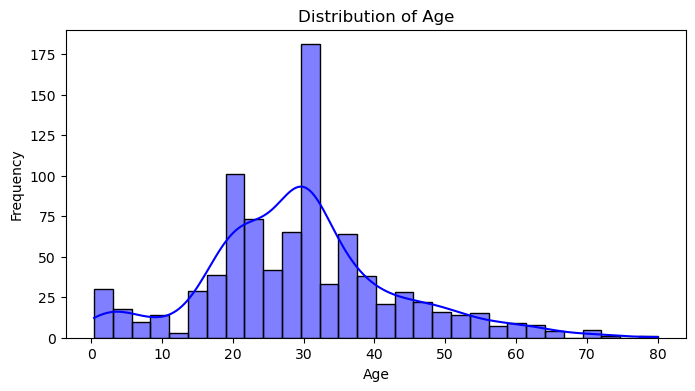

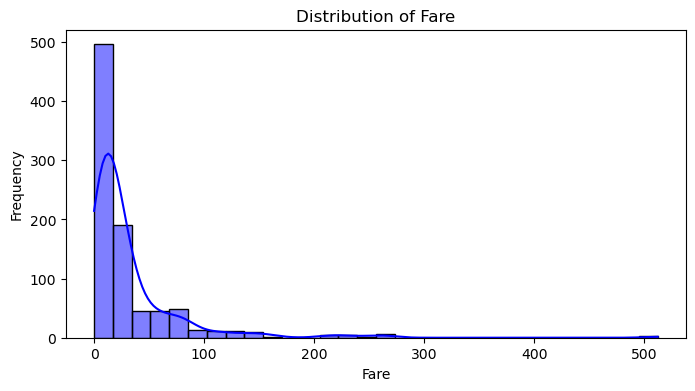

In [40]:
numerical_columns = ['Age', 'Fare']
for column in numerical_columns:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[column], kde=True, bins=30, color='blue')
    plt.title(f"Distribution of {column}")
    plt.xlabel(column)
    plt.ylabel("Frequency")
    plt.show()

In [41]:
df[['Age', 'Fare']].describe()

,Age,Fare
count,891.000000,891.000000
mean,29.390202,32.204208
std,13.265322,49.693429
min,0.420000,0.000000
25%,21.000000,7.910400
50%,30.000000,14.454200
75%,35.000000,31.000000
max,80.000000,512.329200


#### **Descriptive Statistics Table (Count, Mean, Std, etc.):**
| **Metric** | **Age**                          | **Fare**                          |
|------------|-----------------------------------|------------------------------------|
| **Count**  | 891 passengers with non-missing age values. | 891 passengers with non-missing fare values. |
| **Mean**   | The average age is 29.39 years.  | The average fare paid is 32.20.   |
| **Std (Standard Deviation)** | Age values deviate by ~13.27 from the mean. Indicates moderate spread. | High spread of fares (~49.69) due to varying ticket prices across classes. |
| **Min**    | Youngest passenger is 0.42 years old (infant). | Minimum fare is 0 (likely due to a free ticket). |
| **25% (Q1)** | 25% of passengers are aged 21 or younger. | 25% of fares are <= 7.91. Indicates low-cost tickets dominate. |
| **50% (Median)** | Median age is 30 years. 50% of passengers are older than this. | Median fare is 14.45. |
| **75% (Q3)** | 75% of passengers are aged 35 or younger. | 75% of fares are <= 31.00. Higher-cost tickets are in the top quartile. |
| **Max**    | Oldest passenger is 80 years old. | Highest fare paid is 512.33, likely for first-class luxury cabins. |

---

In [42]:
df[['Age', 'Fare']].agg(['skew', 'kurtosis'])

,Age,Fare
skew,0.436534,4.787317
kurtosis,0.777187,33.398141


#### **Skewness and Kurtosis:**
| **Metric**   | **Age**                            | **Fare**                          |
|--------------|------------------------------------|------------------------------------|
| **Skewness** | 0.44 (Moderately Right-Skewed)     | 4.79 (Heavily Right-Skewed)       |
| **Kurtosis** | 0.78 (Platykurtic)                 | 33.40 (Leptokurtic with extreme tails) |

- **Age**:
  - **Skewness**: Positive skew (0.44) indicates a slight tail towards higher ages.
  - **Kurtosis**: Below 3, indicating a flatter distribution than normal.
- **Fare**:
  - **Skewness**: Highly right-skewed (4.79) due to a few extremely high ticket prices.
  - **Kurtosis**: Extremely high (33.40), showing sharp peaks and long tails. Outliers dominate this distribution.

---

In [43]:
df[['Age', 'Fare']].quantile([0.25, 0.5, 0.75])

,Age,Fare
0.25,21.0,7.9104
0.50,30.0,14.4542
0.75,35.0,31.0000


#### **Percentiles:**
| **Percentile** | **Age**      | **Fare**     |
|----------------|--------------|--------------|
| **25% (Q1)**   | 21.0 years   | 7.91         |
| **50% (Median)** | 30.0 years | 14.45        |
| **75% (Q3)**   | 35.0 years   | 31.00        |

- **Age**:
  - Spread between Q1 (21) and Q3 (35) shows a moderate range of middle-aged passengers.
- **Fare**:
  - Large spread between Q1 (7.91) and Q3 (31.00) indicates variability in ticket costs, with most tickets clustering around lower fares.

---

In [44]:
Q1 = df[['Age', 'Fare']].quantile(0.25)
Q3 = df[['Age', 'Fare']].quantile(0.75)
IQR = Q3 - Q1
IQR

Age     14.0000
Fare    23.0896
dtype: float64

#### **Interquartile Range (IQR):**
| **Feature** | **IQR**                      |
|-------------|------------------------------|
| **Age**     | 35.0 - 21.0 = 14.0           |
| **Fare**    | 31.0 - 7.91 = 23.09          |

- **Age**: Moderate IQR indicates reasonable variation in passenger ages.
- **Fare**: Large IQR highlights the disparity between cheaper and more expensive tickets.

---

#### Are These Distributions Normal?
1. **Age**:
   - **Skewness**: Slightly right-skewed (near 0), closer to normal distribution.
   - **Kurtosis**: Below 3, indicating a flatter curve.
   - **Conclusion**: **Near-normal distribution**, with slight skewness towards older ages.

2. **Fare**:
   - **Skewness**: Highly right-skewed due to extreme values.
   - **Kurtosis**: Extremely leptokurtic (very sharp peaks and long tails).
   - **Conclusion**: **Not normally distributed**, heavily skewed by high-priced tickets.

#### Insights:
- **Age**: Can generally be treated as approximately normal for many analyses.
- **Fare**: Requires transformation (e.g., logarithmic) if normality is necessary for modeling.

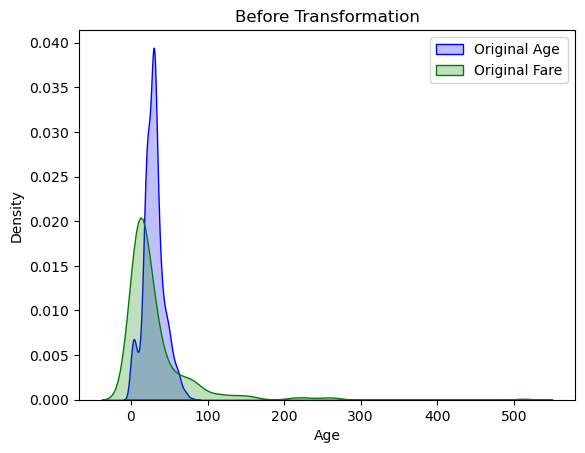

In [45]:
sns.kdeplot(df['Age'], fill=True, label='Original Age', color='blue')
sns.kdeplot(df['Fare'], fill=True, label='Original Fare', color='green')
plt.title('Before Transformation')
plt.legend()
plt.show()

In [46]:
df['Fare_Log'] = np.log1p(df['Fare'])
df['Age_Log'] = np.log1p(df['Age'])

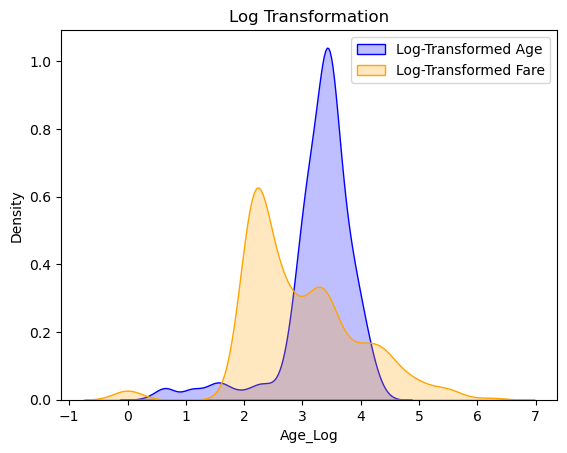

In [47]:
sns.kdeplot(df['Age_Log'], fill=True, label='Log-Transformed Age', color='blue')
sns.kdeplot(df['Fare_Log'], fill=True, label='Log-Transformed Fare', color='orange')
plt.title('Log Transformation')
plt.legend()
plt.show()

In [48]:
df['Fare_Sqrt'] = np.sqrt(df['Fare'])
df['Age_Sqrt'] = np.sqrt(df['Age'])

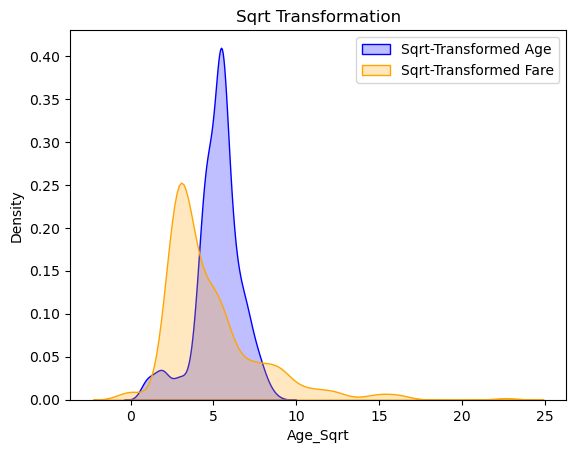

In [49]:
sns.kdeplot(df['Age_Sqrt'], fill=True, label='Sqrt-Transformed Age', color='blue')
sns.kdeplot(df['Fare_Sqrt'], fill=True, label='Sqrt-Transformed Fare', color='orange')
plt.title('Sqrt Transformation')
plt.legend()
plt.show()

---

#### Visualize categorical variables

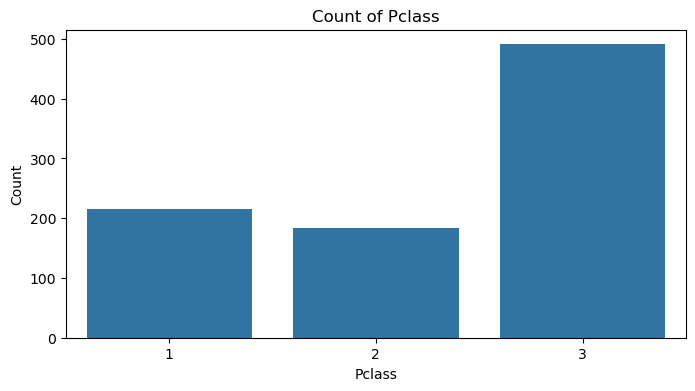

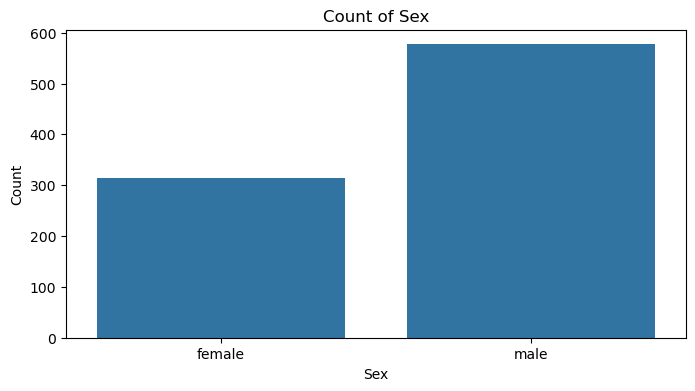

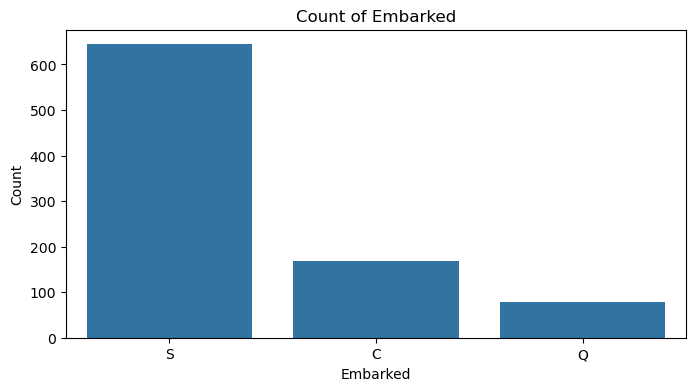

In [50]:
categorical_columns = ['Pclass', 'Sex', 'Embarked']
for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=column)
    plt.title(f"Count of {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.show()

#### Relationships between Survived and other features

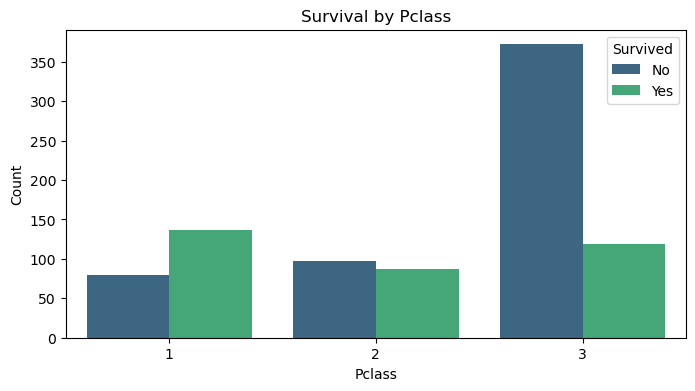

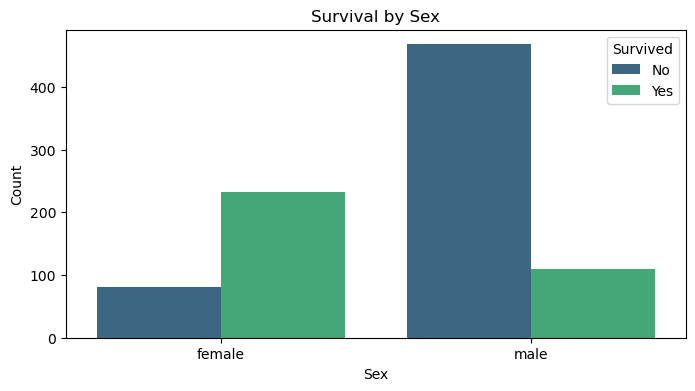

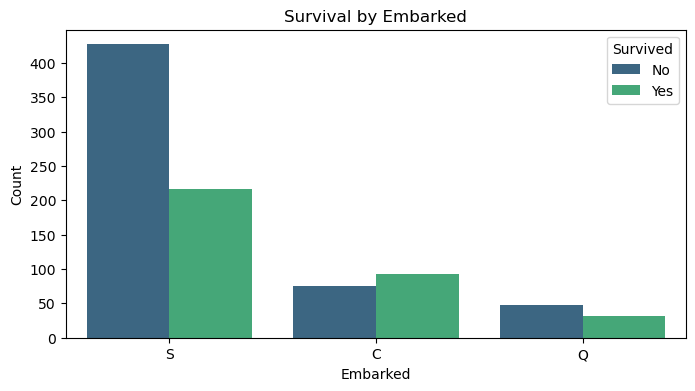

In [51]:
for column in categorical_columns:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=column, hue='Survived', palette="viridis")
    plt.title(f"Survival by {column}")
    plt.xlabel(column)
    plt.ylabel("Count")
    plt.legend(title="Survived", labels=["No", "Yes"])
    plt.show()

#### Correlation analysis for numerical columns.

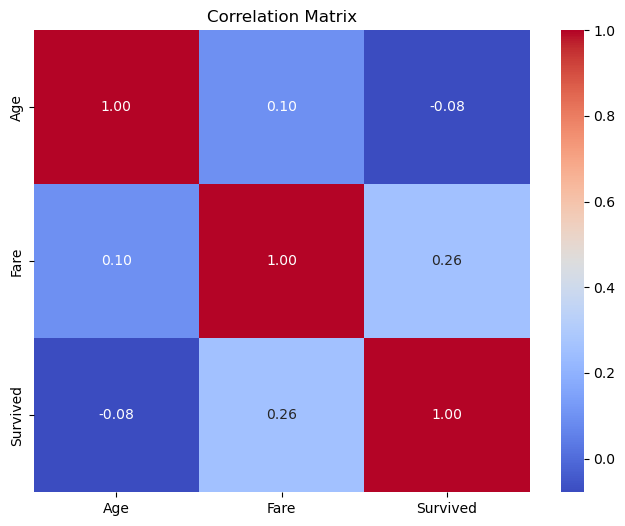

In [52]:
plt.figure(figsize=(8, 6))
corr_matrix = df[numerical_columns + ['Survived']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---

### **3. Encode Data**
   - Encoding data is essential for converting categorical variables into numerical formats that machine learning algorithms can process effectively.
   - There are several encoding techniques depending on the type of data and requirements:
     - **Label Encoding**:
       - Assigns a unique numeric value to each category.
       - Suitable for ordinal variables (e.g., `Pclass` in Titanic data).
     - **One-Hot Encoding**:
       - Creates binary columns for each category, marking `1` if the category is present and `0` otherwise.
       - Preferred for nominal variables (e.g., `Embarked`).
     - **Target Encoding**:
       - Maps categories to their mean target value.
       - Useful for high cardinality categorical variables.

#### **Steps for Encoding**
1. **Identify Categorical Variables**:
   - Use `df.select_dtypes(include=['object', 'category'])` to find all categorical columns.

2. **Choose Encoding Method**:
   - **Label Encoding**:
     - Use `sklearn.preprocessing.LabelEncoder`.
   - **One-Hot Encoding**:
     - Use `pandas.get_dummies()` or `sklearn.preprocessing.OneHotEncoder`.
   - **Target Encoding**:
     - Use `category_encoders.TargetEncoder`.


#### **Label Encoding for Ordinal Variables**

In [53]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df['Sex'] = label_encoder.fit_transform(df['Sex'])

---

#### **One-Hot Encoding for Nominal Variables**

In [54]:
df = pd.get_dummies(df, columns=['Embarked'], drop_first=True)
df = pd.get_dummies(df, columns=['Pclass'], prefix='Pclass', drop_first=True)

---

#### **Target Encoding for High Cardinality**

In [55]:
from category_encoders import TargetEncoder

target_encoder = TargetEncoder()
df['Ticket'] = target_encoder.fit_transform(df['Ticket'], df['Survived'])

---

#### Tips for Best Practices:
- Use **Label Encoding** for features like `Sex` or `Pclass` with inherent order.
- Use **One-Hot Encoding** for features like `Embarked` with no inherent order.
- Consider **Target Encoding** for high-cardinality features (like `Ticket` or `Cabin`) if you're optimizing for model performance.

These encoding steps ensure categorical variables are transformed effectively for machine learning models.

In [56]:
df['Ticket_Number'] = df['Ticket_Number'].astype(int)

In [57]:
max_survived_mapping = df.groupby('Title_Grouped')['Survived'].agg(lambda x: x.value_counts().idxmax())

In [58]:
df['Title_Grouped_Encoded'] = df['Title_Grouped'].map(max_survived_mapping)

In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Survived               891 non-null    int64  
 1   Name                   891 non-null    object 
 2   Sex                    891 non-null    int64  
 3   Age                    891 non-null    float64
 4   SibSp                  891 non-null    int64  
 5   Parch                  891 non-null    int64  
 6   Ticket                 891 non-null    float64
 7   Fare                   891 non-null    float64
 8   Has_Cabin              891 non-null    int64  
 9   Ticket_Number          891 non-null    int64  
 10  Title                  891 non-null    object 
 11  Title_Grouped          891 non-null    object 
 12  Fare_Log               891 non-null    float64
 13  Age_Log                891 non-null    float64
 14  Fare_Sqrt              891 non-null    float64
 15  Age_Sq

---

---

### **4. Multicollinearity**
   - Compute the correlation matrix for numerical features (`Age`, `Fare`, `SibSp`, `Parch`).
   - Identify highly correlated features (correlation > 0.8 or 0.9).
   - Remove or combine highly correlated features (e.g., `SibSp` and `Parch` might be combined into a `FamilySize` feature).

In [60]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

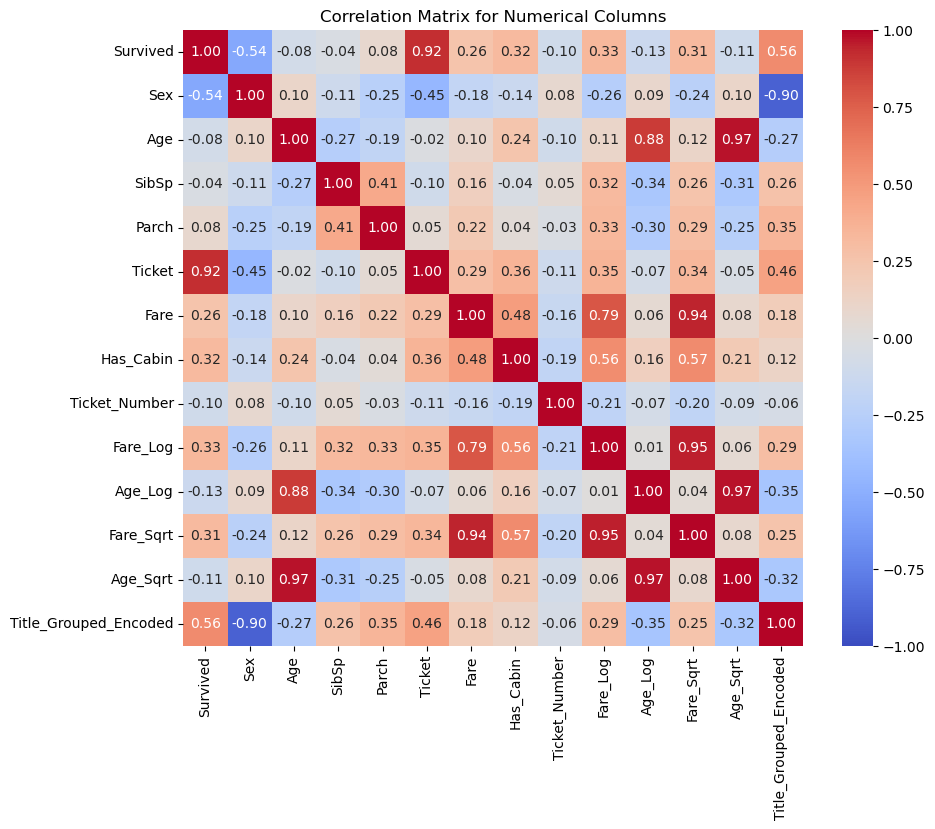

In [61]:
correlation_matrix = df[numerical_columns].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

In [62]:
threshold = 0.9
high_corr_features = [
    (col1, col2)
    for col1 in correlation_matrix.columns
    for col2 in correlation_matrix.columns
    if col1 != col2 and abs(correlation_matrix.loc[col1, col2]) > threshold
]
high_corr_features

[('Survived', 'Ticket'),
 ('Sex', 'Title_Grouped_Encoded'),
 ('Age', 'Age_Sqrt'),
 ('Ticket', 'Survived'),
 ('Fare', 'Fare_Sqrt'),
 ('Fare_Log', 'Fare_Sqrt'),
 ('Age_Log', 'Age_Sqrt'),
 ('Fare_Sqrt', 'Fare'),
 ('Fare_Sqrt', 'Fare_Log'),
 ('Age_Sqrt', 'Age'),
 ('Age_Sqrt', 'Age_Log'),
 ('Title_Grouped_Encoded', 'Sex')]

In [63]:
df.drop(columns=['Ticket' , 'Sex' , 'Age' , 'Fare'] , inplace=True)

In [64]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
numerical_columns = [col for col in numerical_columns if col not in ['Fare_Log', 'Age_Log']]

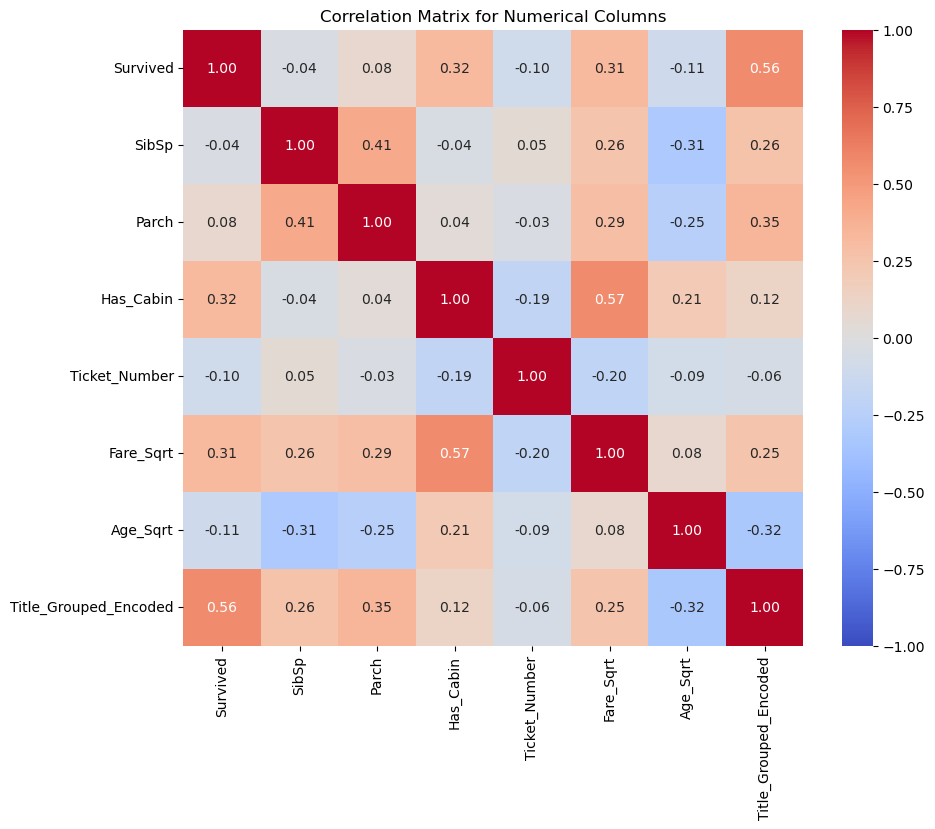

In [65]:
correlation_matrix = df[numerical_columns].corr()


plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

---

### **5. Outliers**
   - Identify outliers in numerical columns using:
     - Box plots.
     - Z-scores or IQR method.
   - Decide on outlier treatment:
     - Remove them if they are errors.
     - Cap them at reasonable thresholds.

In [66]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

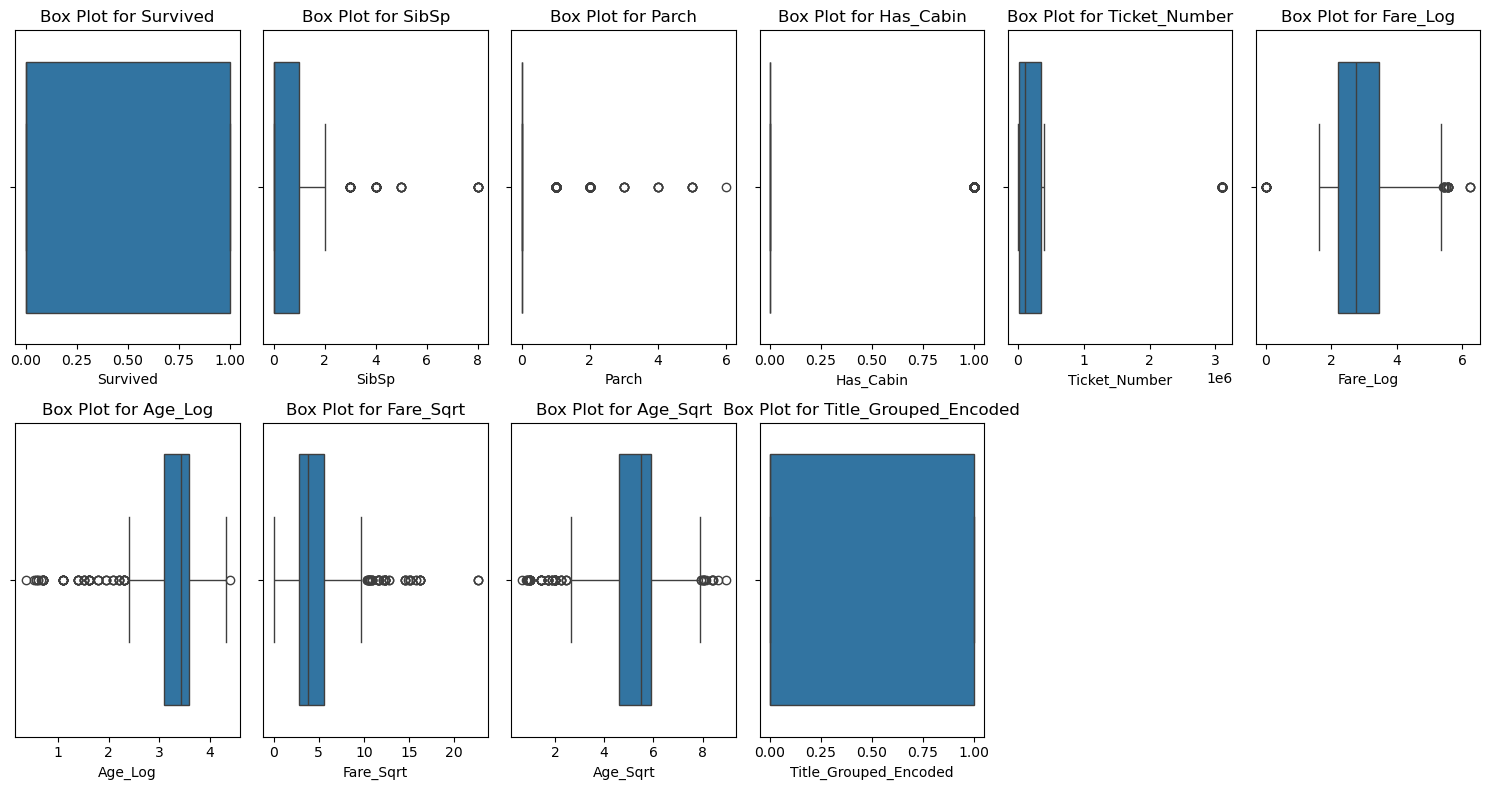

In [67]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns) // 2 + 1, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Box Plot for {col}')
plt.tight_layout()
plt.show()

In [68]:
from scipy.stats import zscore

z_scores = np.abs(zscore(df[numerical_columns]))
outliers_z = (z_scores > 3).any(axis=1)  # Threshold = 3

In [69]:
# IQR Method
outliers_iqr = []
for col in numerical_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers_col = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))
    outliers_iqr.append(outliers_col.sum())

In [70]:
print("Outliers Summary:")
print("Z-score Method:", outliers_z.sum())
for col, count in zip(numerical_columns, outliers_iqr):
    print(f"{col}: {count} (IQR Method)")

Outliers Summary:
Z-score Method: 139
Survived: 0 (IQR Method)
SibSp: 46 (IQR Method)
Parch: 213 (IQR Method)
Has_Cabin: 204 (IQR Method)
Ticket_Number: 44 (IQR Method)
Fare_Log: 31 (IQR Method)
Age_Log: 67 (IQR Method)
Fare_Sqrt: 53 (IQR Method)
Age_Sqrt: 66 (IQR Method)
Title_Grouped_Encoded: 0 (IQR Method)


#### **Insights from the Summary**:

1. **Z-Score Method**:
   - **139 Outliers Detected**: This counts all rows with at least one feature having a z-score greater than 3.
   - This method is useful for identifying global outliers across all features.

2. **IQR Method**:
   - **`Survived`: 0 Outliers**:
     - This categorical column has no outliers as it’s binary (0 or 1).
   - **`SibSp`: 46 Outliers**:
     - The number of siblings/spouses aboard may have extreme values.
   - **`Parch`: 213 Outliers**:
     - A high number of parents/children aboard is rare and flagged as outliers.
   - **`Has_Cabin`: 204 Outliers**:
     - This feature might have imbalances because many passengers don’t have cabin information.
   - **`Ticket_Number`: 44 Outliers**:
     - Ticket numbers might have rare numerical patterns flagged as outliers.
   - **Transformed Columns (`Fare_Log`, `Age_Log`, `Fare_Sqrt`, `Age_Sqrt`)**:
     - These outliers could indicate unusual distributions even after transformations.
   - **`Title_Grouped_Encoded`: 0 Outliers**:
     - This is a categorical/encoded column, and its values are controlled.

#### **Actions Based on Outliers**:

1. **Categorical Features (`Survived`, `Title_Grouped_Encoded`)**:
   - No action required, as these are encoded or binary and show no outliers.

2. **`SibSp` and `Parch`**:
   - Consider combining them into a new `FamilySize` feature for better representation:

In [71]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1  # Include the passenger
df.drop(columns=['SibSp', 'Parch'], inplace=True)

In [72]:
Q1 = df['FamilySize'].quantile(0.25)
Q3 = df['FamilySize'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['FamilySize'] = np.where(df['FamilySize'] > upper_bound, upper_bound, df['FamilySize'])

3. **Transformed Features (`Fare_Log`, `Age_Log`)**:
   - If these transformations still show outliers:
     - Use **capping** to limit extreme values:

In [73]:
for col in ['Fare_Log', 'Age_Log']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))

In [74]:
for col in ['Fare_Sqrt', 'Age_Sqrt']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[col] = np.where(df[col] < lower_bound, lower_bound,
                       np.where(df[col] > upper_bound, upper_bound, df[col]))

4. **`Has_Cabin` and `Ticket_Number`**:
   - These features may have inherent imbalances. Consider normalizing or standardizing them for better handling in models:

In [75]:
Q1 = df['Ticket_Number'].quantile(0.25)
Q3 = df['Ticket_Number'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df['Ticket_Number'] = np.where(df['Ticket_Number'] > upper_bound, upper_bound,
                               np.where(df['Ticket_Number'] < lower_bound, lower_bound, df['Ticket_Number']))

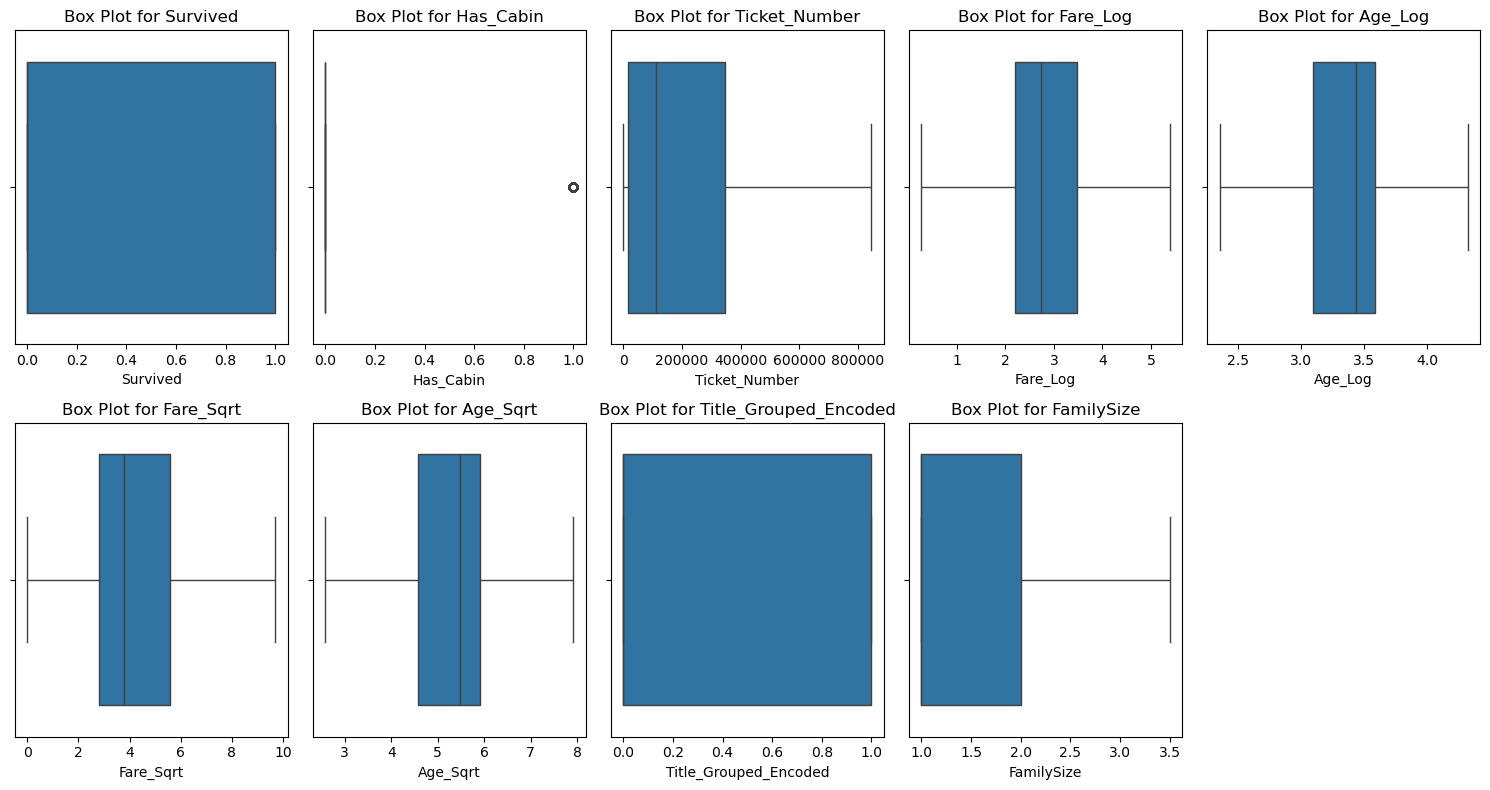

In [76]:
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns

plt.figure(figsize=(15, 8))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, len(numerical_columns) // 2 + 1, i)
    sns.boxplot(data=df, x=col)
    plt.title(f'Box Plot for {col}')
plt.tight_layout()
plt.show()

In [77]:
df.head()

,Survived,Name,Has_Cabin,Ticket_Number,Title,Title_Grouped,Fare_Log,Age_Log,Fare_Sqrt,Age_Sqrt,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_Grouped_Encoded,FamilySize
0,0,"Braund, Mr. Owen Harris",0,21171.00,Mr,Mr,2.110213,3.135494,2.692582,4.690416,False,True,False,True,0,2.0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,17599.00,Mrs,Mrs,4.280593,3.663562,8.442944,6.164414,False,False,False,False,1,2.0
2,1,"Heikkinen, Miss. Laina",0,846236.25,Miss,Miss,2.188856,3.295837,2.815138,5.099020,False,True,False,True,1,1.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,113803.00,Mrs,Mrs,3.990834,3.583519,7.286975,5.916080,False,True,False,False,1,2.0
4,0,"Allen, Mr. William Henry",0,373450.00,Mr,Mr,2.202765,3.583519,2.837252,5.916080,False,True,False,True,0,1.0


### **6. Scaling Data**
   - Scaling ensures that numerical features have a uniform range, which is essential for machine learning algorithms sensitive to feature magnitudes.
   - Common techniques for scaling data include:
     - **Standardization**:
       - Centers the data to have a mean of 0 and a standard deviation of 1.
       - Suitable for algorithms like SVM, logistic regression, and PCA.
     - **Normalization**:
       - Scales data to a range of [0, 1].
       - Suitable for distance-based algorithms like k-NN and neural networks.
     - **Robust Scaling**:
       - Uses the median and interquartile range to scale data, making it robust to outliers.
   - Apply scaling only to numerical features. Avoid scaling categorical or one-hot encoded features.

In [78]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Has_Cabin,891.0,0.228956,0.420397,0.000000,0.000000,0.000000,0.000000,1.000000
Ticket_Number,891.0,185628.621773,211243.092664,3.000000,14312.500000,112058.000000,347082.000000,846236.250000
Fare_Log,891.0,2.962066,0.942199,0.269441,2.187218,2.737881,3.465736,5.383513
Age_Log,891.0,3.340262,0.432382,2.352328,3.091042,3.433987,3.583519,4.322234
Fare_Sqrt,891.0,4.634825,2.280471,0.000000,2.812542,3.801868,5.567764,9.700598
Age_Sqrt,891.0,5.298943,1.201545,2.582320,4.582576,5.477226,5.916080,7.916336
Title_Grouped_Encoded,891.0,0.398429,0.489850,0.000000,0.000000,0.000000,1.000000,1.000000
FamilySize,891.0,1.664983,0.914151,1.000000,1.000000,1.000000,2.000000,3.500000


To determine the best scaling technique, consider the following key factors about the dataset:

1. **`Survived` and `Title_Grouped_Encoded`**:
   - Binary features (values of 0 or 1).
   - **No scaling required** for these as they are already in a normalized form.

2. **`Has_Cabin`**:
   - Also binary (values of 0 or 1).
   - **No scaling required** for this feature.

3. **`Ticket_Number`, `Fare_Log`, `Age_Log`, `Fare_Sqrt`, `Age_Sqrt`**:
   - Continuous numerical features with varying distributions and ranges.
   - **Log or Standard Scaling** would likely be most appropriate.

4. **`FamilySize`**:
   - Small integer values (range: 1 to 3.5).
   - **Normalization or Standard Scaling** would work well depending on the machine learning model.

1. **Binary Features** (`Survived`, `Has_Cabin`, `Title_Grouped_Encoded`):
   - Leave these as-is; scaling is unnecessary.

2. **Continuous Features** (`Fare_Log`, `Age_Log`, `Fare_Sqrt`, `Age_Sqrt`):
   - If these features already represent logarithmic or square root transformations (as suggested by their names), use **Standard Scaling (Z-score normalization)** to standardize the distribution.

In [79]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

columns_to_scale = ["Fare_Log", "Age_Log", "Fare_Sqrt", "Age_Sqrt"]

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

3. **`Ticket_Number`**:
   - Since this feature has a high range, scaling is necessary.
   - Consider **Min-Max Scaling** to compress the values into a uniform range (0 to 1).

4. **`FamilySize`**:
   - If working with distance-based models (like k-NN or SVMs), use **Standard Scaling** to center and standardize.
   - For tree-based models (like Random Forest), scaling is less critical, but **Min-Max Scaling** can be used.

In [80]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

columns_to_scale = ['Ticket_Number' , 'FamilySize']

df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])

In [81]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,3.838384e-01,0.486592,0.000000,0.000000,0.000000,1.000000,1.000000
Has_Cabin,891.0,2.289562e-01,0.420397,0.000000,0.000000,0.000000,0.000000,1.000000
Ticket_Number,891.0,2.193552e-01,0.249628,0.000000,0.016910,0.132416,0.410146,1.000000
Fare_Log,891.0,-5.831474e-17,1.000562,-2.859415,-0.822845,-0.238072,0.534868,2.571438
Age_Log,891.0,2.791133e-17,1.000562,-2.286148,-0.576711,0.216887,0.562913,2.272350
Fare_Sqrt,891.0,-1.674680e-16,1.000562,-2.033540,-0.799531,-0.365462,0.409329,2.222619
Age_Sqrt,891.0,0.000000e+00,1.000562,-2.262212,-0.596540,0.148461,0.513908,2.179580
Title_Grouped_Encoded,891.0,3.984287e-01,0.489850,0.000000,0.000000,0.000000,1.000000,1.000000
FamilySize,891.0,2.659933e-01,0.365660,0.000000,0.000000,0.000000,0.400000,1.000000


#### General Strategy:
- Use **Standard Scaling** for normally distributed features or those transformed into a logarithmic or square root scale.
- Use **Min-Max Scaling** for features with large ranges or those where preserving the proportional relationships is important.
- Leave binary features unchanged. 

Would you like a code snippet combining these scaling strategies for your dataset?

---

### **7. Imbalanced Data**
   - Check the balance of the target variable (`Survived`) using value counts or visualizations.
   - If the dataset is imbalanced, consider techniques like:
     - Oversampling (e.g., SMOTE).
     - Undersampling.
     - Class weights during model training.

In [82]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

In [83]:
df.head()

,Survived,Name,Has_Cabin,Ticket_Number,Title,Title_Grouped,Fare_Log,Age_Log,Fare_Sqrt,Age_Sqrt,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Title_Grouped_Encoded,FamilySize
0,0,"Braund, Mr. Owen Harris",0,0.025014,Mr,Mr,-0.904620,-0.473847,-0.852163,-0.506739,False,True,False,True,0,0.4
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,0.020793,Mrs,Mrs,1.400200,0.748138,1.670821,0.720703,False,False,False,False,1,0.4
2,1,"Heikkinen, Miss. Laina",0,1.000000,Miss,Miss,-0.821105,-0.102803,-0.798392,-0.166482,False,True,False,True,1,0.0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,0.134478,Mrs,Mrs,1.092493,0.562913,1.163637,0.513908,False,True,False,False,1,0.4
4,0,"Allen, Mr. William Henry",0,0.441305,Mr,Mr,-0.806335,0.562913,-0.788689,0.513908,False,True,False,True,0,0.0


In [84]:
X = df.drop(columns=['Survived' , 'Name' , 'Title_Grouped' , 'Title'])
y = df['Survived']

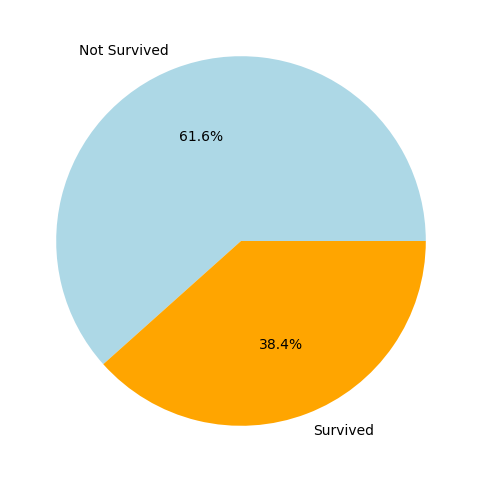

In [85]:
plt.figure(figsize=(8, 6))
plt.pie(y.value_counts(), labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['lightblue', 'orange'])
plt.show()

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [87]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

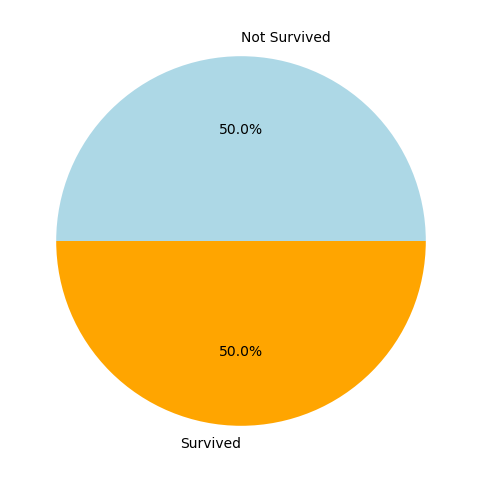

In [88]:
plt.figure(figsize=(8, 6))
plt.pie(y_train_resampled.value_counts(), labels=['Not Survived', 'Survived'], autopct='%1.1f%%', colors=['lightblue', 'orange'])
plt.show()

---

### **Simple Decision Tree**
   - Train a simple Decision Tree model using `DecisionTreeClassifier` from `sklearn`.
   - The model is initialized with a fixed `random_state` to ensure reproducibility.
     - **Accuracy**: Percentage of correct predictions.
     - **Classification Report**: Provides precision, recall, F1-score, and support for each class.

In [89]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn import tree

In [90]:
dt_model = DecisionTreeClassifier(random_state=42)

In [91]:
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [92]:
y_pred = dt_model.predict(X_test)

In [93]:
print(f"Accuracy: {accuracy_score(y_test, y_pred)*100 :.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 75.42

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.79      0.79       105
           1       0.70      0.70      0.70        74

    accuracy                           0.75       179
   macro avg       0.75      0.75      0.75       179
weighted avg       0.75      0.75      0.75       179



#### **Accuracy**
- **Value**: `0.75`
- **Explanation**: 
  - This is the overall accuracy of the model, indicating that approximately 76% of the predictions made by the Decision Tree are correct.
  - Formula:  
    $
    \text{Accuracy} = \frac{\text{Number of Correct Predictions}}{\text{Total Number of Predictions}}
    $

---

#### **Classification Report**
The classification report gives detailed metrics for each class (e.g., `0` and `1`), as well as macro and weighted averages.

#### **Class-Specific Metrics**

1. **Class `0` (Not Survived)**:
   - **Precision**: `0.79`
     - Out of all instances predicted as `0`, 79% were actually `0`.
     - Formula:  
       $
       \text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
       $
   - **Recall**: `0.79`
     - Out of all actual `0` instances, the model correctly identified 79% as `0`.
     - Formula:  
       $
       \text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
       $
   - **F1-Score**: `0.79`
     - The harmonic mean of precision and recall, balancing both metrics.
     - Formula:  
       $
       \text{F1-Score} = 2 \cdot \frac{\text{Precision} \cdot \text{Recall}}{\text{Precision} + \text{Recall}}
       $
   - **Support**: `105`
     - Total number of true instances of class `0` in the test set.

2. **Class `1` (Survived)**:
   - **Precision**: `0.70`
     - Out of all instances predicted as `1`, 70% were actually `1`.
   - **Recall**: `0.70`
     - Out of all actual `1` instances, the model correctly identified 70% as `1`.
   - **F1-Score**: `0.70`
     - Balances precision and recall for class `1`.
   - **Support**: `74`
     - Total number of true instances of class `1` in the test set.

---

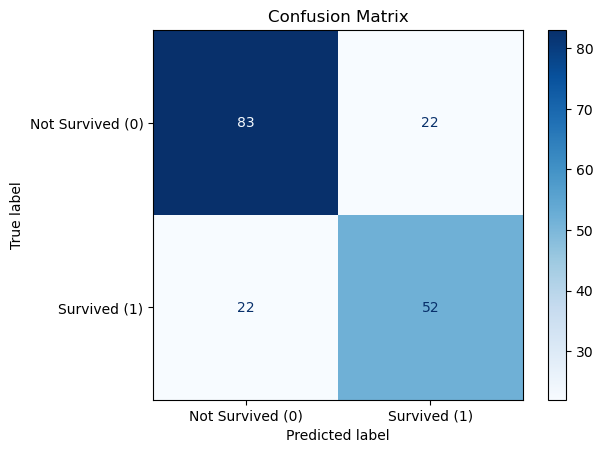

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived (0)', 'Survived (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [95]:
import pickle

# Save the model to a file
with open('../Model/dt_model.pkl', 'wb') as f:
    pickle.dump(dt_model, f)

---

### **GridSearch**

In [96]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'criterion': ['gini', 'entropy'],  # Valid criteria
    'max_depth': [None, 3, 5, 7, 10],  # Valid depth values
    'min_samples_split': [2, 5, 10],  # Must be >= 2
    'min_samples_leaf': [1, 2, 4],  # Must be >= 1
    'max_features': [None ,'sqrt', 'log2']  # Valid feature selectors
}



#### **Parameter Descriptions**:

1. **`criterion`**:
   - Specifies the function used to measure the quality of a split at each node in the tree.
   - The decision tree evaluates this function to decide the best feature and value to split the data.

2. **`max_depth`**:
   - Defines the maximum depth of the tree.
   - A shallower tree (lower depth) prevents overfitting but may lead to underfitting, while a deeper tree can capture more patterns but risks overfitting.

3. **`min_samples_split`**:
   - The minimum number of samples required to split an internal node.
   - Higher values enforce stricter rules for splitting, reducing the likelihood of overfitting by creating fewer splits.

4. **`min_samples_leaf`**:
   - The minimum number of samples required to be at a leaf node.
   - This prevents creating leaf nodes with very few samples, ensuring more reliable predictions and reducing overfitting.

5. **`max_features`**:
   - Limits the number of features considered when looking for the best split.
   - This introduces randomness and can improve generalization, especially in ensemble methods like Random Forests.

---

#### **How These Parameters Work Together**:
- **`criterion`** determines how the tree splits data.
- **`max_depth`**, **`min_samples_split`**, and **`min_samples_leaf`** control the tree's structure and complexity.
- **`max_features`** adds randomness to the feature selection process, which can help prevent overfitting.

In [97]:
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    return_train_score=True 
)

In [98]:
grid_search.fit(X_train_resampled, y_train_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 7, 10],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             return_train_score=True, scoring='accuracy')

In [99]:
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", grid_search.best_score_)

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Accuracy: 0.8153875452294802


In [100]:
best_dt_model = grid_search.best_estimator_

   - After training:
     - The best parameters and their corresponding accuracy are printed.
     - The model with the best parameters (`best_dt_model`) is used to predict the test data.
     - The test data's performance is evaluated using:
       - **Accuracy**: Percentage of correct predictions.
       - **Classification Report**: Precision, recall, F1-score, and support for each class.

In [101]:
cv_results = grid_search.cv_results_
cv_results_df = pd.DataFrame(cv_results)

cv_results_df = cv_results_df[[
    'mean_test_score', 'std_test_score', 'params'
]]

cv_results_df = cv_results_df.sort_values(by='mean_test_score', ascending=False)
cv_results_df.head()

,mean_test_score,std_test_score,params
129,0.815388,0.029245,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
120,0.815388,0.029245,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
113,0.815343,0.027666,"{'criterion': 'gini', 'max_depth': 10, 'max_fe..."
5,0.813090,0.024018,"{'criterion': 'gini', 'max_depth': None, 'max_..."
141,0.813083,0.019724,"{'criterion': 'entropy', 'max_depth': None, 'm..."


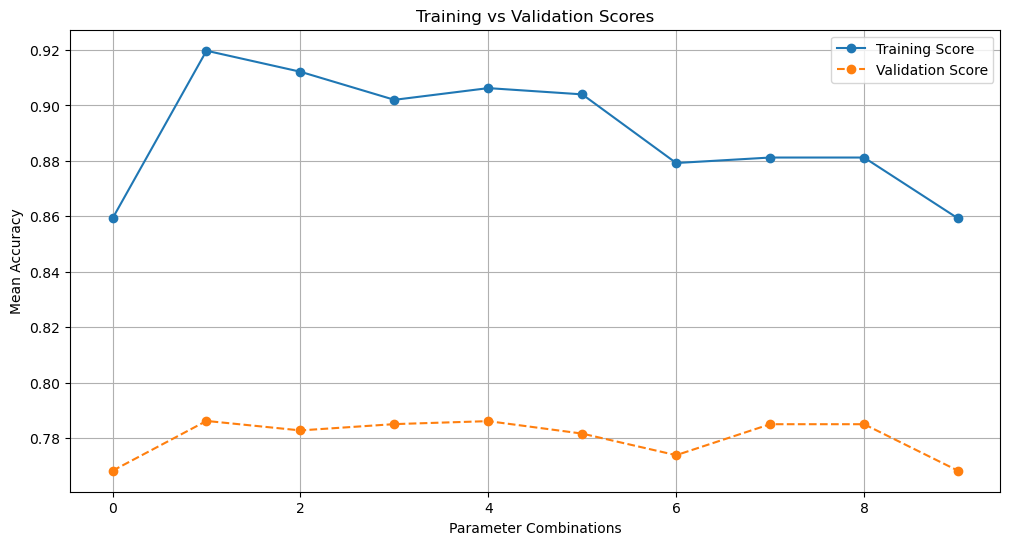

In [102]:
mean_train_scores = grid_search.cv_results_['mean_train_score'][-10::]
mean_validation_scores = grid_search.cv_results_['mean_test_score'][-10::]

# Plot scores
plt.figure(figsize=(12, 6))
plt.plot(mean_train_scores, label='Training Score', marker='o')
plt.plot(mean_validation_scores, label='Validation Score', marker='o', linestyle='--')
plt.title('Training vs Validation Scores')
plt.xlabel('Parameter Combinations')
plt.ylabel('Mean Accuracy')
plt.legend()
plt.grid()
plt.show()

In [103]:
y_pred_best = best_dt_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_best):.2f}")
print("\nClassification Report with Best Parameters:\n", classification_report(y_test, y_pred_best))

Accuracy: 0.83

Classification Report with Best Parameters:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       105
           1       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



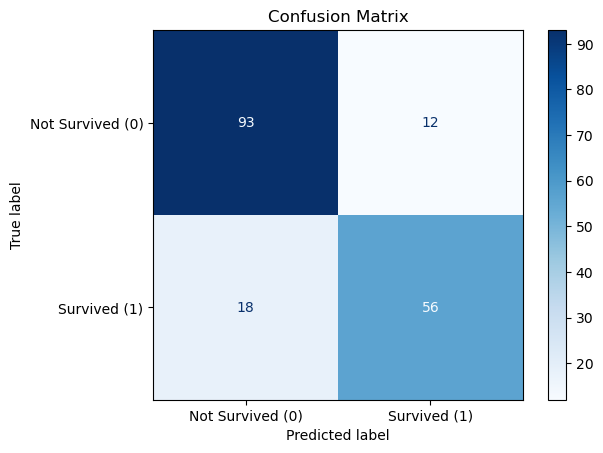

In [104]:
cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived (0)', 'Survived (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

---

### **Voting**

- Combine multiple Decision Tree classifiers using majority voting to improve overall model accuracy and robustness.


In [105]:
from sklearn.ensemble import VotingClassifier
from sklearn.utils import shuffle

1. **Shuffling Data**:
   - `shuffle(df, random_state=42)`: Randomizes the dataset to avoid any bias during subset creation.

In [106]:
df_shuffled = shuffle(df, random_state=42)

2. **Creating Balanced Subsets**:
   - The `create_balanced_subset` function ensures equal representation of both classes (`class 0` and `class 1`) by:
     - Sampling an equal number of rows from each class.
     - Creating three balanced subsets (`X_balanced1`, `X_balanced2`, `X_balanced3`) using different random states.

In [107]:
def create_balanced_subset(X, y, random_state):
    """
    Create a balanced subset of data by ensuring equal representation of both classes.

    Parameters:
    - X: pandas DataFrame or Series (Feature set)
    - y: pandas Series (Target labels corresponding to X)
    - random_state: int (Seed for reproducibility in random sampling)

    Returns:
    - X_balanced: pandas DataFrame or Series (Balanced feature set)
    - y_balanced: pandas Series (Balanced target labels)
    """
    # Separate rows belonging to class 0
    class_0 = X[y == 0]
    
    # Separate rows belonging to class 1
    class_1 = X[y == 1]
    
    # Find the smaller class size to ensure balance
    min_size = min(len(class_0), len(class_1))
    
    # Randomly sample 'min_size' rows from class 0
    balanced_class_0 = class_0.sample(n=min_size, random_state=random_state)
    
    # Randomly sample 'min_size' rows from class 1
    balanced_class_1 = class_1.sample(n=min_size, random_state=random_state)
    
    # Combine the balanced samples into a single dataset
    X_balanced = pd.concat([balanced_class_0, balanced_class_1])
    
    # Extract the corresponding target labels using the indices of the balanced features
    y_balanced = y.loc[X_balanced.index]
    
    # Return the balanced feature set and corresponding target labels
    return X_balanced, y_balanced

In [108]:
X_balanced1, y_balanced1 = create_balanced_subset(X, y, random_state=42)
X_balanced2, y_balanced2 = create_balanced_subset(X, y, random_state=43)
X_balanced3, y_balanced3 = create_balanced_subset(X, y, random_state=44)

3. **Individual Decision Trees**:
   - Three Decision Tree models (`tree1`, `tree2`, and `tree3`) are initialized with identical hyperparameters (`criterion='entropy'`, `max_depth=7`, etc.) but different random states to ensure variability.

In [109]:
tree1 = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                                min_samples_leaf=1, min_samples_split=2, random_state=42)

tree2 = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                                min_samples_leaf=1, min_samples_split=2, random_state=43)

tree3 = DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                                min_samples_leaf=1, min_samples_split=2, random_state=44)

**Balanced Class Distributions**:
   - Ensures all balanced subsets have equal representation of classes (`50%-50%`).

In [110]:
print("Tree 1 Class Distribution:\n", y_balanced1.value_counts(normalize=True))
print("Tree 2 Class Distribution:\n", y_balanced2.value_counts(normalize=True))
print("Tree 3 Class Distribution:\n", y_balanced3.value_counts(normalize=True))

Tree 1 Class Distribution:
 Survived
0    0.5
1    0.5
Name: proportion, dtype: float64
Tree 2 Class Distribution:
 Survived
0    0.5
1    0.5
Name: proportion, dtype: float64
Tree 3 Class Distribution:
 Survived
0    0.5
1    0.5
Name: proportion, dtype: float64


4. **Training Individual Models**:
   - `tree1` and `tree2` are trained on `X_balanced2` and `y_balanced2`.
   - `tree3` is trained on `X_balanced3` and `y_balanced3`.

In [111]:
tree1.fit(X_balanced2, y_balanced2)
tree2.fit(X_balanced2, y_balanced2)
tree3.fit(X_balanced3, y_balanced3)

DecisionTreeClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                       random_state=44)

5. **Voting Classifier**:
   - Combines `trees` using `VotingClassifier` with `voting='hard'`, where predictions are based on the majority class predicted by the individual classifiers.

In [112]:
voting_clf = VotingClassifier(
    estimators=[
        ('tree1', tree1),
        ('tree2', tree2),
        ('tree3', tree3)
    ],
    voting='hard'  # Majority voting
)

The choice of `voting='hard'` in a **`VotingClassifier`** refers to **majority voting**, where the final prediction is based on the class predicted by the majority of the classifiers in the ensemble. Here’s why and how it works, as well as how it differs from **`voting='soft'`**:

---

#### **What is Hard Voting?**
- In **hard voting**, each classifier predicts a class label (e.g., 0 or 1), and the final prediction is determined by the majority vote among the classifiers.
- If two classifiers predict `1` and one classifier predicts `0`, the ensemble prediction will be `1`.

---

#### **Why Use Hard Voting?**
1. **Simple and Intuitive**:
   - Hard voting is straightforward: it chooses the class that most classifiers agree on.
   - It works well when individual classifiers have high accuracy and make independent predictions.

2. **Classifiers Without Probabilities**:
   - Some classifiers (e.g., Decision Trees, SVMs without probability calibration) may not output probabilities reliably. In such cases, soft voting might not be applicable.

3. **Majority Rule**:
   - It aligns with the principle that combining multiple models can reduce individual errors when they are independent and diverse.

---

#### **Soft Voting: How It Differs**
- In **soft voting**, the final prediction is based on the **average predicted probabilities** of each class from all classifiers.
- Each classifier outputs probabilities (e.g., `[0.7, 0.3]` for class `1` and class `0`), and these are averaged for each class. The class with the highest averaged probability is selected as the final prediction.

---

#### **Comparison: Hard Voting vs. Soft Voting**

| **Aspect**           | **Hard Voting**                          | **Soft Voting**                               |
|-----------------------|------------------------------------------|-----------------------------------------------|
| **Definition**        | Majority class prediction.              | Weighted average of predicted probabilities.  |
| **Output Type**       | Class labels (e.g., 0, 1).              | Probabilities for each class.                 |
| **Use Case**          | Works well when all models are accurate. | Works better when models are calibrated.      |
| **Applicability**     | Suitable for classifiers that don’t output probabilities. | Requires classifiers that output probabilities. |
| **Diversity**         | Depends on individual classifier labels. | Utilizes confidence levels in predictions.    |

---

#### **Example**
1. **Hard Voting**:
   - Classifier 1: Predicts `1`
   - Classifier 2: Predicts `0`
   - Classifier 3: Predicts `1`
   - **Final Prediction**: `1` (majority class is `1`).

2. **Soft Voting**:
   - Classifier 1: Probability `[0.8, 0.2]` (for class `1` and `0`)
   - Classifier 2: Probability `[0.3, 0.7]`
   - Classifier 3: Probability `[0.9, 0.1]`
   - Average probabilities: `[ (0.8+0.3+0.9)/3 , (0.2+0.7+0.1)/3 ] = [0.67, 0.33]`
   - **Final Prediction**: `1` (higher probability is for class `1`).

---

#### **When to Use Each?**
- **Hard Voting**:
  - When individual classifiers are reliable.
  - If some classifiers do not produce probabilities.
  - Simpler implementation and interpretation.

- **Soft Voting**:
  - When classifiers output well-calibrated probabilities.
  - If probability confidence is crucial (e.g., for imbalanced datasets).
  - Typically more accurate when models are diverse and well-trained.

---

In [113]:
voting_clf.fit(X_balanced2, y_balanced2)

VotingClassifier(estimators=[('tree1',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     max_features='sqrt',
                                                     random_state=42)),
                             ('tree2',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     max_features='sqrt',
                                                     random_state=43)),
                             ('tree3',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     max_features='sqrt',
                                                     random_state=44))])

6. **Testing Data Preparation**:
   - The testing dataset (`X_test` and `y_test`) is prepared by slicing the last 179 rows of the original dataset.

In [114]:
X_test = X.iloc[-len(X_balanced1):]
y_test = y.iloc[-len(X_balanced1):]

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")


X_test = X.iloc[-179:]  
y_test = y.iloc[-179:]  

print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_test shape: (684, 12)
y_test shape: (684,)
X_test shape: (179, 12)
y_test shape: (179,)


 **Testing Data Size**:
   - Ensures `X_test` and `y_test` have exactly 179 rows:

In [115]:
print("Tree 3 Class Distribution:\n", y_test.value_counts(normalize=True))

Tree 3 Class Distribution:
 Survived
0    0.642458
1    0.357542
Name: proportion, dtype: float64


In [116]:
y_pred = voting_clf.predict(X_test)

7. **Predictions**:
   - `voting_clf.predict(X_test)`: Predicts the test labels using the Voting Classifier.

In [117]:
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.88

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       115
           1       0.84      0.83      0.83        64

    accuracy                           0.88       179
   macro avg       0.87      0.87      0.87       179
weighted avg       0.88      0.88      0.88       179



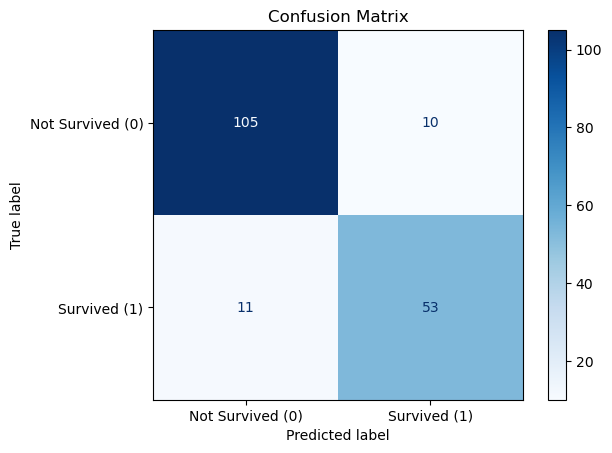

In [118]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived (0)', 'Survived (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [119]:
import pickle

# Save the model to a file
with open('../Model/voting_model.pkl', 'wb') as f:
    pickle.dump(voting_clf, f)

---

### **Boosting**

Boosting is an ensemble learning technique that builds models sequentially, where each model focuses on correcting the errors of the previous one. It combines the predictions of multiple weak learners (e.g., shallow decision trees) to create a strong learner. Below are three popular boosting algorithms implemented and evaluated:

In [120]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### **1. Gradient Boosting**
- **Algorithm**: Gradient Boosting Classifier
  - Sequentially builds trees, minimizing a loss function (e.g., log loss for classification).
- **Steps**:
  - The model is initialized with `GradientBoostingClassifier` and trained on `X_train_resampled` and `y_train_resampled` to handle imbalanced data.
  - The trained model predicts on `X_test`, and the accuracy is evaluated.
- **Advantages**:
  - Robust to overfitting with proper hyperparameter tuning.
  - Can handle various types of data distributions.

In [121]:
from sklearn.ensemble import GradientBoostingClassifier

In [122]:
model = GradientBoostingClassifier(random_state=42)

In [123]:
model.fit(X_train_resampled, y_train_resampled)

GradientBoostingClassifier(random_state=42)

In [124]:
y_pred = model.predict(X_test)

In [125]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.84


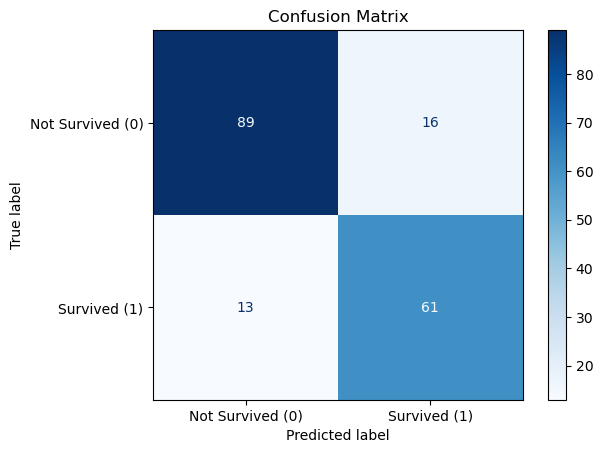

In [126]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived (0)', 'Survived (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

---

#### **2. XGBoost**
- **Algorithm**: Extreme Gradient Boosting (XGBoost)
  - An optimized implementation of gradient boosting with faster training speed and better performance.
- **Steps**:
  - The model is initialized with `XGBClassifier`, using `eval_metric='logloss'` to specify the evaluation metric for optimization.
  - Trained on the original `X_train` and `y_train`, then predictions are made on `X_test` and accuracy is calculated.
- **Advantages**:
  - High performance with built-in regularization to prevent overfitting.
  - Efficient handling of missing data and support for parallel computing.

In [127]:
from xgboost import XGBClassifier

In [128]:
model = XGBClassifier(random_state=42, eval_metric='logloss')

In [129]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [130]:
y_pred = model.predict(X_test)

In [131]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.83


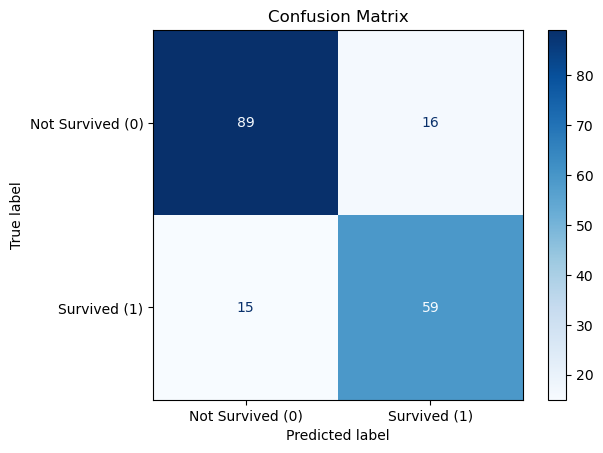

In [132]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived (0)', 'Survived (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

---

#### **3. LightGBM**
- **Algorithm**: Light Gradient Boosting Machine (LightGBM)
  - A gradient boosting framework that uses histogram-based algorithms for faster computation.
- **Steps**:
  - The model is initialized with `LGBMClassifier` and trained on `X_train` and `y_train`.
  - Predictions are made on `X_test`, and the model's accuracy is evaluated.
- **Advantages**:
  - Extremely fast training and prediction.
  - Better performance on large datasets and datasets with high cardinality features.

In [133]:
from lightgbm import LGBMClassifier

In [134]:
model = LGBMClassifier(random_state=42)

In [ ]:
model.fit(X_train, y_train)

In [136]:
y_pred = model.predict(X_test)

In [137]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.85


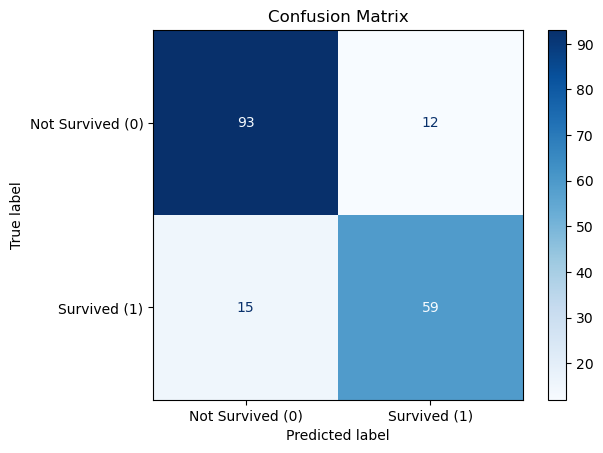

In [138]:
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Survived (0)', 'Survived (1)'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

---
---